In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import wilcoxon
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error


from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#import GC corrected data
data = pd.read_csv('../../merge/data_with_features.txt', sep='\t')
data = data[(data['tumor_fraction']>=0.1) & (data['ulp_wgs_coverage']>=0.1) & (data['merged_updated_ER_status_binary']!='none')]
data = data[data['sample'].str.contains('ULP')]
print(len(data['sample'].unique()))

stat_results = pd.DataFrame()

for site_name in data['site_name'].unique():
    current = data[data['site_name']==site_name]
    current_outputs = {'site_name':site_name}
    for feature in ['mean_cov','central_cov','fft_10_magnitude']:

        #pearson r plus regression line
        lin_reg_slope, lin_reg_intercept, pearson_r, pearson_pval, lin_reg_std_err = linregress(current['tumor_fraction'],current[feature])
        fit_line = lin_reg_slope*current['tumor_fraction']+lin_reg_intercept
        #r2 = r2_score(current[feature],fit_line)
        RMSE = np.sqrt(mean_squared_error(current[feature],fit_line))
        
        current_outputs['pearson_r_'+feature] = pearson_r
        current_outputs['pearson_pval_'+feature] = pearson_pval
        current_outputs['lin_reg_slope_'+feature] = lin_reg_slope
        current_outputs['lin_reg_intercept_'+feature] = lin_reg_intercept
        #current_outputs['lin_reg_r2_'+feature] = r2
        current_outputs['lin_reg_RMSE_'+feature] = RMSE

        
    stat_results = stat_results.append(current_outputs, ignore_index=True)
stat_results = stat_results.set_index('site_name') 

191


In [3]:
#import data without GC correction
uncorrected_data = pd.read_csv('../../merge/no_GC_correction_data_with_features.txt', sep='\t')
uncorrected_data = uncorrected_data[(uncorrected_data['tumor_fraction']>=0.1) & (uncorrected_data['ulp_wgs_coverage']>=0.1) & (uncorrected_data['merged_updated_ER_status_binary']!='none')]
uncorrected_data = uncorrected_data[uncorrected_data['sample'].str.contains('ULP')]
print(len(uncorrected_data['sample'].unique()))

uncorrected_stat_results = pd.DataFrame()

for site_name in uncorrected_data['site_name'].unique():
    current = uncorrected_data[uncorrected_data['site_name']==site_name]
    current_outputs = {'site_name':site_name}
    for feature in ['mean_cov','central_cov','fft_10_magnitude']:

        #spearman r
        #spearman_r,spearman_pval = spearmanr(current['tumor_fraction'],current[feature])
        #current_outputs['spearman_r_'+feature] = spearman_r
        #current_outputs['spearman_pval_'+feature] = spearman_pval
        
        #pearson r plus regression line
        lin_reg_slope, lin_reg_intercept, pearson_r, pearson_pval, lin_reg_std_err = linregress(current['tumor_fraction'],current[feature])
        fit_line = lin_reg_slope*current['tumor_fraction']+lin_reg_intercept
        #r2 = r2_score(current[feature],fit_line)
        RMSE = np.sqrt(mean_squared_error(current[feature],fit_line))
        
        current_outputs['pearson_r_'+feature] = pearson_r
        current_outputs['pearson_pval_'+feature] = pearson_pval
        current_outputs['lin_reg_slope_'+feature] = lin_reg_slope
        current_outputs['lin_reg_intercept_'+feature] = lin_reg_intercept
        #current_outputs['lin_reg_r2_'+feature] = r2
        current_outputs['lin_reg_RMSE_'+feature] = RMSE
        
    uncorrected_stat_results = uncorrected_stat_results.append(current_outputs, ignore_index=True)

uncorrected_stat_results = uncorrected_stat_results.set_index('site_name')

191


In [4]:
merged_stat_results = stat_results.merge(uncorrected_stat_results, left_index=True,right_index=True, suffixes=['_GC_corrected','_uncorrected'])
merged_stat_results.to_csv('tfx_correlation_statistics.txt',sep='\t')

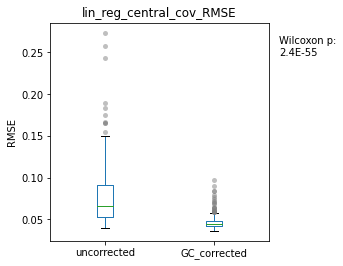

In [6]:
fig,ax = plt.subplots(1, figsize=(5,3.8))
ax.set_title('lin_reg_central_cov_RMSE')
ax.set_ylabel('RMSE')
merged_stat_results[['lin_reg_RMSE_central_cov_uncorrected','lin_reg_RMSE_central_cov_GC_corrected']].plot.box(ax=ax, flierprops = {'marker':'.','markersize':10,'alpha':.5,'markerfacecolor':'grey','markeredgecolor':'none'})

#add LYL1
#ax.scatter([1,2],merged_stat_results[['lin_reg_RMSE_central_cov_uncorrected','lin_reg_RMSE_central_cov_GC_corrected']].loc['LYL1.hg38'],color='tab:orange', alpha = 0.5, s = 10)

ax.set_xticklabels(['uncorrected','GC_corrected'])

# plt.scatter(1,merged_stat_results.loc['LYL1.hg38']['lin_reg_RMSE_central_cov_uncorrected'], color='tab:orange')
# plt.scatter(2,merged_stat_results.loc['LYL1.hg38']['lin_reg_RMSE_central_cov_GC_corrected'], color='tab:orange')

fig.tight_layout()
stat,wilcoxon_pval = wilcoxon(merged_stat_results['lin_reg_RMSE_central_cov_uncorrected'],merged_stat_results['lin_reg_RMSE_central_cov_GC_corrected'])
plt.text(1.05,.85, 'Wilcoxon p:\n'+'{:.1E}'.format(wilcoxon_pval), transform=ax.transAxes)

ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
fig.tight_layout()
fig.savefig('RMSE_boxplot.pdf')

In [7]:
len(merged_stat_results)

338

In [8]:
print('wilcoxon stat',stat)
print('wilcoxon p', wilcoxon_pval)

wilcoxon stat 472.0
wilcoxon p 2.391752562915051e-55


In [9]:
#get the number of factors with reduced RMSE
sum(merged_stat_results['lin_reg_RMSE_central_cov_uncorrected']>merged_stat_results['lin_reg_RMSE_central_cov_GC_corrected'])

325

In [10]:
#export for supplementary tables
rename_dict = {
    #central_cov uncorrected columns
    'pearson_r_central_cov_uncorrected':'central_cov_pearson_r_uncorrected',
    'pearson_pval_central_cov_uncorrected':'central_cov_pearson_pval_uncorrected',
    'lin_reg_RMSE_central_cov_uncorrected':'central_cov_lin_reg_RMSE_uncorrected',

    #central_cov GC corrected columns
    'pearson_r_central_cov_GC_corrected':'central_cov_pearson_r_GC_corrected',
    'pearson_pval_central_cov_GC_corrected':'central_cov_pearson_pval_GC_corrected',
    'lin_reg_RMSE_central_cov_GC_corrected':'central_cov_lin_reg_RMSE_GC_corrected',
    
    #mean_cov uncorrected columns
    'pearson_r_mean_cov_uncorrected':'mean_cov_pearson_r_uncorrected',
    'pearson_pval_mean_cov_uncorrected':'mean_cov_pearson_pval_uncorrected',
    'lin_reg_RMSE_mean_cov_uncorrected':'mean_cov_lin_reg_RMSE_uncorrected',
              
    #mean_cov GC corrected columns
    'pearson_r_mean_cov_GC_corrected':'mean_cov_pearson_r_GC_corrected',
    'pearson_pval_mean_cov_GC_corrected':'mean_cov_pearson_pval_GC_corrected',
    'lin_reg_RMSE_mean_cov_GC_corrected':'mean_cov_lin_reg_RMSE_GC_corrected',

    #amplitude uncorrected columns
    'pearson_r_fft_10_magnitude_uncorrected':'amplitude_pearson_r_uncorrected',
    'pearson_pval_fft_10_magnitude_uncorrected':'amplitude_pearson_pval_uncorrected',
    'lin_reg_RMSE_fft_10_magnitude_uncorrected':'amplitude_lin_reg_RMSE_uncorrected',

    #amplitude GC corrected columns
    'pearson_r_fft_10_magnitude_GC_corrected':'amplitude_pearson_r_GC_corrected',
    'pearson_pval_fft_10_magnitude_GC_corrected':'amplitude_pearson_pval_GC_corrected',
    'lin_reg_RMSE_fft_10_magnitude_GC_corrected':'amplitude_lin_reg_RMSE_GC_corrected'}


new_col_order = [
    #central_cov
    'central_cov_pearson_r_uncorrected','central_cov_pearson_r_GC_corrected',
    'central_cov_pearson_pval_uncorrected','central_cov_pearson_pval_GC_corrected',
    'central_cov_lin_reg_RMSE_uncorrected','central_cov_lin_reg_RMSE_GC_corrected',
    
    #mean_cov uncorrected columns
    'mean_cov_pearson_r_uncorrected','mean_cov_pearson_r_GC_corrected',
    'mean_cov_pearson_pval_uncorrected','mean_cov_pearson_pval_GC_corrected',
    'mean_cov_lin_reg_RMSE_uncorrected','mean_cov_lin_reg_RMSE_GC_corrected',

    #amplitude uncorrected columns
    'amplitude_pearson_r_uncorrected','amplitude_pearson_r_GC_corrected',
    'amplitude_pearson_pval_uncorrected','amplitude_pearson_pval_GC_corrected',
    'amplitude_lin_reg_RMSE_uncorrected','amplitude_lin_reg_RMSE_GC_corrected']




to_export = merged_stat_results.rename(columns = rename_dict)[new_col_order]

to_export.to_csv('S1_MBC_RMSE.txt',sep='\t')


In [12]:
stat_results.sort_values(by= 'pearson_r_central_cov').head(20)['pearson_r_central_cov']

site_name
GRHL2.hg38    -0.625179
FOXM1.hg38    -0.458784
FOXA1.hg38    -0.419397
AHR.hg38      -0.396874
PGR.hg38      -0.369678
ASCL2.hg38    -0.358314
POU2F1.hg38   -0.357264
TFAP2C.hg38   -0.340430
ZBTB2.hg38    -0.298684
GATA3.hg38    -0.295480
HMGA1.hg38    -0.292498
HIF3A.hg38    -0.286296
SRF.hg38      -0.282928
ZNF486.hg38   -0.281950
ZNF146.hg38   -0.275802
ESR1.hg38     -0.263338
HOXB13.hg38   -0.254202
CTCF.hg38     -0.253380
ESRRA.hg38    -0.253310
NFIB.hg38     -0.252536
Name: pearson_r_central_cov, dtype: float64